# Proyecto: Clasificación de Ritmos Cardíacos con Aprendizaje Automático
Este notebook aborda el análisis y modelado de datos provenientes de un Desfibrilador Externo Automático (DEA).

## Introducción
Los desfibriladores externos automáticos (DEA) son dispositivos que analizan el ritmo cardíaco y determinan si se requiere una descarga eléctrica. El objetivo es desarrollar un modelo supervisado que clasifique correctamente ritmos normales (0) y afectados (1).

## 📥 Ejercicio 1: Carga y Exploración de Datos

### 📊 Instalar librerías

In [1]:
%pip install pandas matplotlib seaborn scikit-learn
%pip install tabulate

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


### 📊 Carga de datos

Se renombra: "VF" por "target" para identificar mejor nuestra columna objetivo

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # Necesaria para algunas operaciones numéricas
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

In [3]:
# Cargar el dataset de entrenamiento y exploración
df_reto = pd.read_csv("D:/IMMUNE/7. Asignatura 7 Aprendizaje automático/Case to be solved/data_reto.csv")

# Renombrar columna objetivo
df_reto.rename(columns={'VF': 'target'}, inplace=True)

In [4]:
def cap_outliers_iqr(df, column):
    """Limita los outliers a 1.5 * IQR para una columna dada."""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Aplicar la limitación (Capping)
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    return df

### 🧹 Limpieza y estandarización de nombres de columnas

In [5]:
# Lista nombres - columnas
current_columns = df_reto.columns

# Limpieza para aplicar a todos los nombres
def clean_col_name(col_name):
    return col_name.strip().lower().replace(' ', '_')

df_reto.columns = [clean_col_name(col) for col in current_columns]

print(df_reto.columns)

Index(['tci', 'tcsc', 'exp', 'expmod', 'cm', 'cvbin', 'frqbin', 'abin', 'kurt',
       'vfleak', 'm', 'a1', 'a2', 'a3', 'mav', 'psr', 'hilb', 'samen', 'x3',
       'x4', 'x5', 'x1', 'x2', 'bcp', 'bwt', 'bw', 'li', 'count1', 'count2',
       'count3', 'target'],
      dtype='object')


### 📊 Primera exploración

#### Info y Value Counts

In [6]:
# Primera Exploración
print(df_reto.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9146 entries, 0 to 9145
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tci     9146 non-null   float64
 1   tcsc    9146 non-null   float64
 2   exp     9146 non-null   int64  
 3   expmod  9146 non-null   int64  
 4   cm      9146 non-null   float64
 5   cvbin   9146 non-null   float64
 6   frqbin  9146 non-null   float64
 7   abin    9146 non-null   int64  
 8   kurt    9146 non-null   float64
 9   vfleak  9146 non-null   float64
 10  m       9146 non-null   float64
 11  a1      9146 non-null   float64
 12  a2      9146 non-null   float64
 13  a3      9146 non-null   float64
 14  mav     9146 non-null   float64
 15  psr     9146 non-null   float64
 16  hilb    9146 non-null   float64
 17  samen   9146 non-null   float64
 18  x3      9146 non-null   float64
 19  x4      9146 non-null   int64  
 20  x5      9146 non-null   float64
 21  x1      9146 non-null   float64
 22  

In [7]:
print("\nConteo de Ritmos Cardíacos:")
print(df_reto['target'].value_counts().to_markdown(index=True))
print("\n--- Distribución Relativa (%) ---")
print(df_reto['target'].value_counts(normalize=True) * 100)


Conteo de Ritmos Cardíacos:
|   target |   count |
|---------:|--------:|
|        0 |    7590 |
|        1 |    1556 |

--- Distribución Relativa (%) ---
target
0    82.987098
1    17.012902
Name: proportion, dtype: float64


##### 🔎 Análisis
**Info:**
- Range Index: 9146 entradas o registros (Ventanas de 4 segundos de ECG para entrenar)
- Non-Null: Count 9146 en todas (No hay valores faltantes o nulos en ninguna columna)
- Dtypes: float64 (26), int64 (5) 
- Columna target (nuestra etiqueta) es un número entero (int64).

**Value counts:**
- Desequilibrio en las clases de ritmo cardíaco:
    - Ritmo Normal (Clase 0): Se identificaron 7,590 muestras.
        - Esto representa aproximadamente el 83% del total de los datos.
    - Ritmo Afectado (Clase 1): Se identificaron 1,556 muestras.
        - Esto representa aproximadamente el 17% del total de los datos.

**Implicación crucial**
- La clase de Ritmo Afectado es la clase minoritaria.
- Obliga el tomar precauciones en el entrenamiento del modelo.
- Ajusta el algoritmo: (Riesgo que el DEA falle en detección de casos realmente afectados)
- Un modelo que sólo prediga la Clase 0 (Ritmo Normal) en todos los casos alcanzaría un accuracy del 83% sin detectar un solo caso de ritmo afectado.
    - El accuracy (que es la métrica de éxito requerida, > 85%) no es suficiente por sí solo.
    - Prestar especial atención a métricas como Recall, F1-Score y el AUC-ROC
        - Para asegurar detección de clase minoritaria (Ritmo Afectado/Clase 1), crítica para un DEA.

Visualización general inicial

Distribución de la clase (target)

C:\Users\Admin\AppData\Local\Temp\ipykernel_22368\2468401551.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target', data=df_reto, palette=['skyblue', 'salmon'])


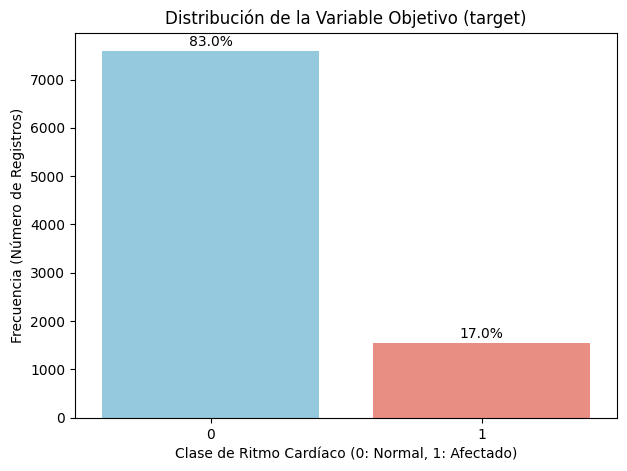

In [8]:
plt.figure(figsize=(7, 5))
# Usamos 'target' para la variable X
sns.countplot(x='target', data=df_reto, palette=['skyblue', 'salmon'])

# Añadir etiquetas y título
plt.title('Distribución de la Variable Objetivo (target)')
plt.xlabel('Clase de Ritmo Cardíaco (0: Normal, 1: Afectado)')
plt.ylabel('Frecuencia (Número de Registros)')

# Calcular y mostrar las proporciones en el gráfico
total = len(df_reto)
for p in plt.gca().patches:
    height = p.get_height()
    percentage = f'{100 * height / total:.1f}%'
    plt.gca().text(p.get_x() + p.get_width() / 2., height + 100,
                   percentage, ha="center")

plt.show()

La visualización confirma el marcado desequilibrio de clases (83% vs. 17%), lo que será un factor crítico en la selección y evaluación de modelos.

-----------------------------------------------------------------------------------------------------------------------------------------------------------

## 📥 Ejercicio 2: Análisis Exploratorio de Datos (EDA)

#### Verificación de valores faltantes y duplicados

In [9]:
print("--- Verificación de Valores Faltantes ---")
print(df_reto.isnull().sum().sum()) # Suma total de valores nulos en el DataFrame
print("\n--- Verificación de Filas Duplicadas ---")
print(df_reto.duplicated().sum()) # Conteo de filas completamente duplicadas

--- Verificación de Valores Faltantes ---
0

--- Verificación de Filas Duplicadas ---
0


#### Estadística

In [10]:
print("\n--- Resumen Estadístico Descriptivo ---")
print(df_reto.describe().to_markdown(index=True))


--- Resumen Estadístico Descriptivo ---
|       |      tci |      tcsc |       exp |    expmod |           cm |        cvbin |     frqbin |     abin |        kurt |      vfleak |          m |            a1 |          a2 |          a3 |         mav |          psr |         hilb |       samen |            x3 |         x4 |         x5 |          x1 |            x2 |         bcp |          bwt |         bw |        li |     count1 |    count2 |     count3 |      target |
|:------|---------:|----------:|----------:|----------:|-------------:|-------------:|-----------:|---------:|------------:|------------:|-----------:|--------------:|------------:|------------:|------------:|-------------:|-------------:|------------:|--------------:|-----------:|-----------:|------------:|--------------:|------------:|-------------:|-----------:|----------:|-----------:|----------:|-----------:|------------:|
| count | 9146     | 9146      | 9146      | 9146      | 9146         | 9146         | 9146    

🔎 Hallazgos

| Hallazgo | Breve Explicación | Consecuencia para el Modelo |
| :--- | :--- | :--- |
| **Desbalance de Clases** | Clase "Ritmo Afectado" (1) representa solo el $\approx 17\%$ de las muestras, frente al $\approx 83\%$ de clase "Normal" (0). | **Necesidad de Métricas Robustas:** Se debe priorizar el **Recall**, el **F1-Score** y el **AUC** sobre el simple *Accuracy*. |
| **Escalado** | Las variables (ej. `TCI`) tienen magnitudes de miles, mientras que otras (ej. `A1`) están en el orden de las centésimas. | **Necesidad de Estandarización:** Se debe aplicar `StandardScaler` (o similar) para asegurar que todas las características influyan por igual en el modelo, sin importar su unidad. |
| **Outliers** | Columnas como `kurt` y `TCI` muestran valores máximos exageradamente altos en comparación con el 75% Quartil, indicando una cola larga y valores atípicos. | **Necesidad de Manejo de Outliers:** Para proteger modelos sensibles (SVM, Regresión Logística), se recomienda la **Capsulación (Capping)** para limitar estos valores extremos. |

### 📊 Visualización

Relación de características clave

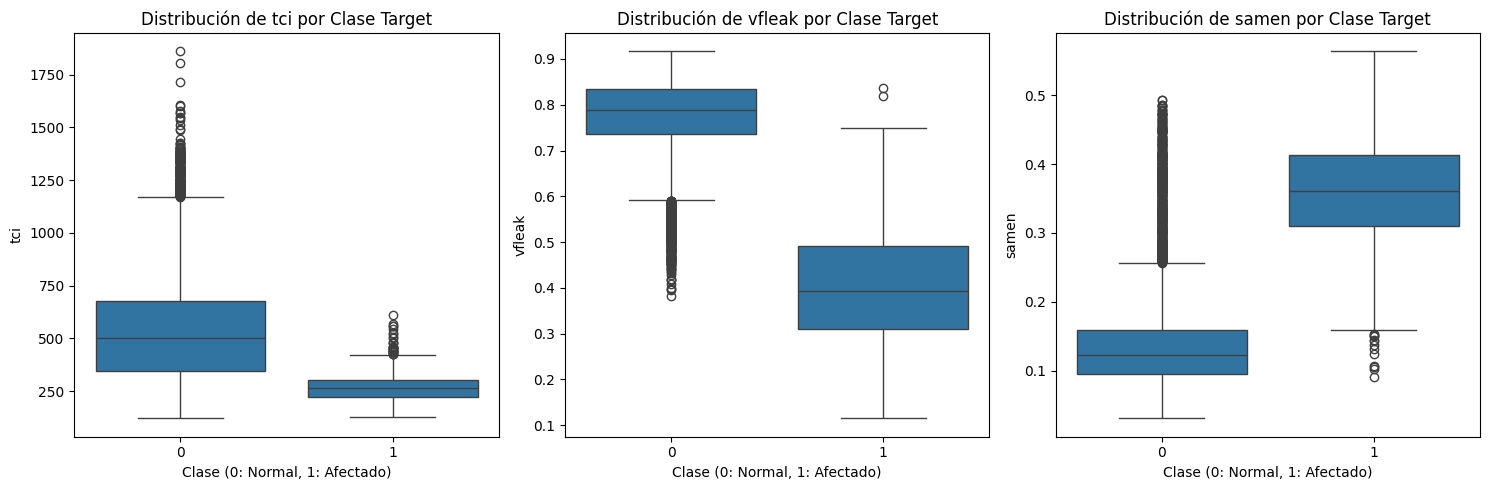

In [11]:
features_to_plot = ['tci', 'vfleak', 'samen'] # Temporal, Espectral, Complejidad

plt.figure(figsize=(15, 5))

for i, feature in enumerate(features_to_plot):
    plt.subplot(1, 3, i + 1)
    # Usamos un gráfico de caja (Box Plot) para ver la distribución por clase
    sns.boxplot(x='target', y=feature, data=df_reto)
    plt.title(f'Distribución de {feature} por Clase Target')
    plt.xlabel('Clase (0: Normal, 1: Afectado)')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

📦 **Box Plots (Análisis X vs. Y)**
- Relación entre cada característica (X) y la variable objetivo (Y/target).
    - Detección de outliers:
        - La longitud de los bigotes y puntos individuales por encima/debajo de estos confirman valores atípicos extremos (TCI o kurt).
    - La caja central (IQR) de la clase 0 (Normal) estaba separada de la caja central de la Clase 1 (Afectado) para muchas variables. 
    
- Consecuencias:
    - Outliers: Implementar técnica de Capsulación (Capping IQR) para limitar estos valores, estabilizando la distribución.
    - Poder Predictivo: Confirma que las variables son determinantes y válidas para la clasificación, lo que nos da confianza para entrenar el modelo.

Histograma

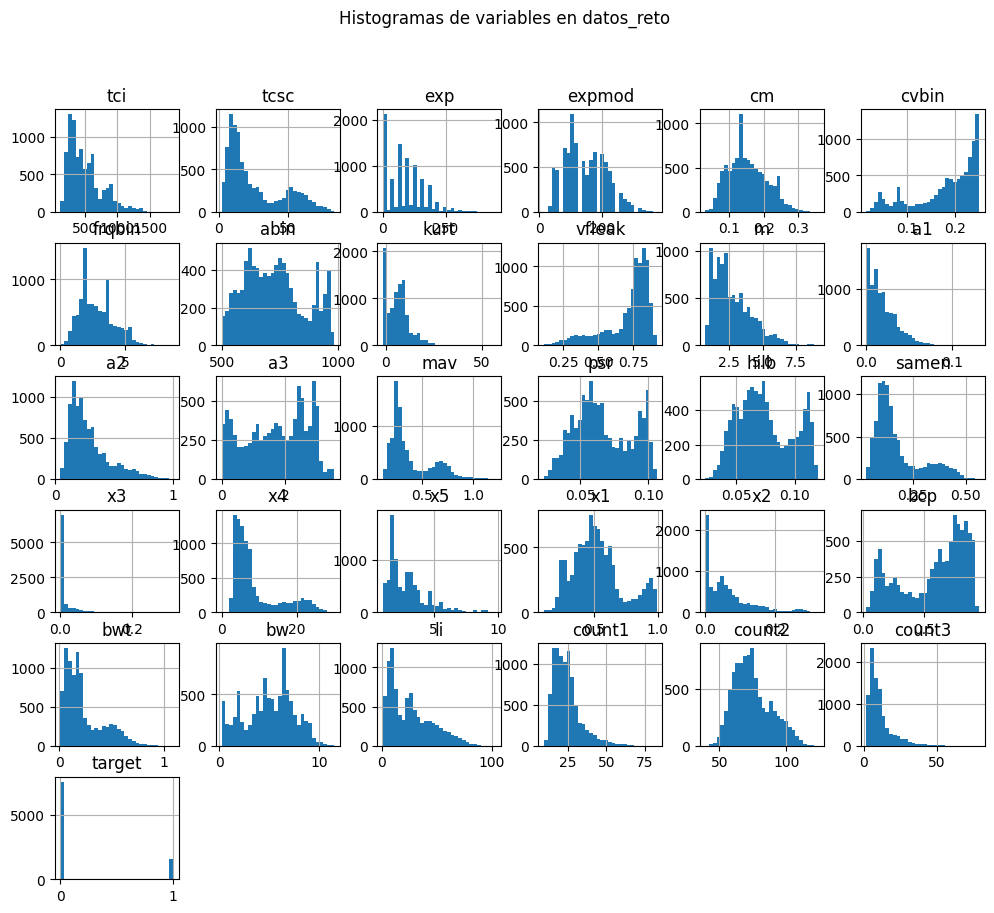

In [12]:
# Histogramas de las primeras variables
df_reto.hist(figsize=(12,10), bins=30)
plt.suptitle('Histogramas de variables en datos_reto')
plt.show()

**Hallazgos**
- tci, exp, expmod, kurt, x4, x5, li:
    - Asimétricas (sesgadas a la derecha). 
        - Preprocesamiento: transformación logarítmica o de raíz cuadrada antes de la estandarización para acercarlas a una distribución normal. 
        - Esto mejora el rendimiento de modelos basados en asunciones de normalidad (como la Regresión Logística).

- tci, kurt, x4:
    - Larga cola derecha confirma presencia de outliers extremos.
        - Manejo de Outliers:
            - Aplicar Capping (Capsulación) antes de entrenar, especialmente para modelos sensibles.

- count1, count2, count3:
    - Variables de conteo que parecen discretas o con distribuciones particulares.
        - Manejar con la estandarización, pero su distribución no es "normal".
        
- target (VF):
    - El histograma de target es un gráfico de barras desequilibrado (pico alto en 0, pico bajo en 1).
        - Confirma desequilibrio y efuerza la necesidad de usar métricas no sesgadas por el accuracy
        - Posiblemente técnicas de balanceo (SMOTE, class weights) en el modelado.

Correlaciones

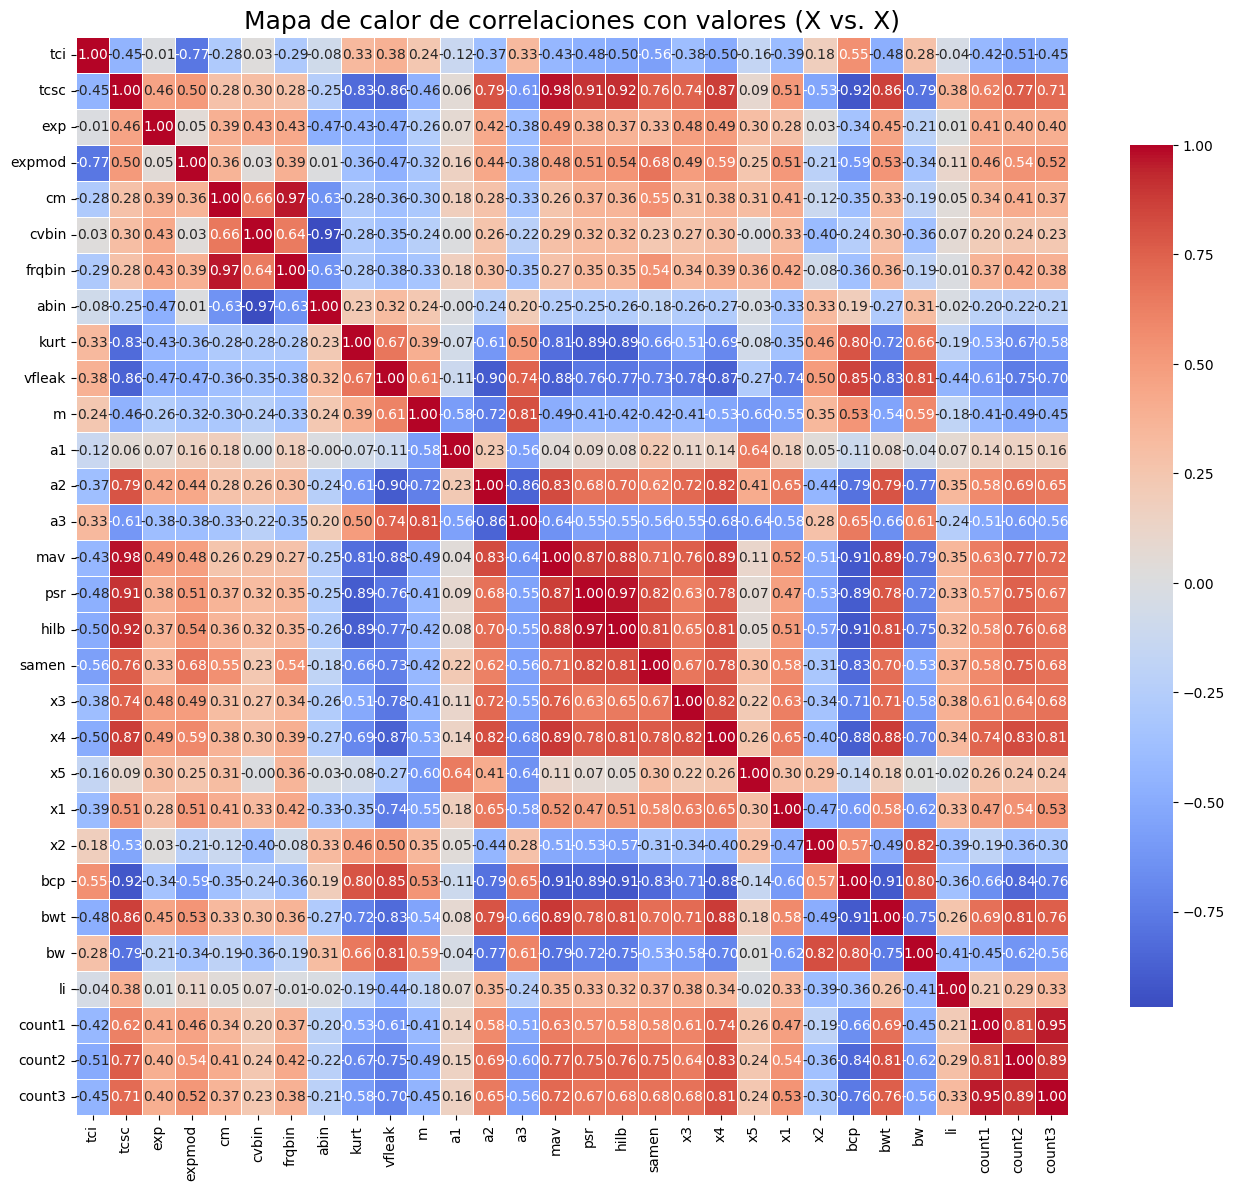

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Matriz de correlación (excluyendo el target)
corr = df_reto.drop(columns=['target']).corr()

# Tamaño del gráfico
plt.figure(figsize=(16, 14))

# Mapa de calor
sns.heatmap(
    corr,
    annot=True,        # Mostrar número de correlación en la celda
    fmt=".2f",         # Formato a dos decimales
    cmap='coolwarm',   # Paleta de colores para contraste (rojo/azul)
    linewidths=.5,     # Líneas para separar celdas y mejor legibilidad
    cbar_kws={'shrink': .8} # Ajuste tamaño de la barra de color
)

plt.title('Mapa de calor de correlaciones con valores (X vs. X)', fontsize=18)
plt.show()

**Problema Detectado**
- Multicolinealidad extrema:
    - La matriz de correlación o mapa de calor reveló pares de características con una correlación > 0.90

**Riesgo en modelado:**
- Redundancia extrema que causa inestabilidad en los coeficientes (pesos) de los modelos lineales
    - Regresión Logística o SVM
    - El modelo no distingue la importancia de las variables colineales (fluctación de pesos)

**Riesgo:**
- Bajo un contexto médico (DEA) la inestabilidad de las predicciones es inaceptable 
    - Aumentar riesgo de falsos negativos y no detectar la anomalía en prueba.

**Solución:**
- Eliminar características:
    - Se elimina una variable de cada par redundante (por ejemplo se eliminó mav y se mantuvo tcsc)
    - Eliminar redundancia asegura robustez, estabilidad e interpretabilidad de los coeficientes del modelo
        - Prioritario para un sistema de soporte vital

Detección automática de multicolinealidad (Umbral > 0.90)

In [14]:
# Umbral de |r| > 0.9.
# Calcular la matriz de correlación
corr_matrix = df_reto.drop(columns=['target']).corr().abs() # Usamos valor absoluto

# DF para almacenar los pares colineales
collinear_pairs = []

# Iterar sobre la mitad inferior de la matriz
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        # Si la correlación es mayor que 0.90
        if corr_matrix.iloc[i, j] >= 0.90:
            collinear_pairs.append({
                'Variable A': corr_matrix.columns[i],
                'Variable B': corr_matrix.columns[j],
                'Correlación (|r|)': corr_matrix.iloc[i, j]
            })

# Formato Markdown
collinear_df = pd.DataFrame(collinear_pairs).sort_values(by='Correlación (|r|)', ascending=False)

print("## 🚨 Detección automática de multicolinealidad (Umbral > 0.90)")
print(collinear_df.to_markdown(index=False, floatfmt=".3f"))

## 🚨 Detección automática de multicolinealidad (Umbral > 0.90)
| Variable A   | Variable B   |   Correlación (|r|) |
|:-------------|:-------------|--------------------:|
| tcsc         | mav          |               0.976 |
| psr          | hilb         |               0.969 |
| cm           | frqbin       |               0.969 |
| cvbin        | abin         |               0.968 |
| count1       | count3       |               0.955 |
| tcsc         | hilb         |               0.917 |
| tcsc         | bcp          |               0.916 |
| hilb         | bcp          |               0.915 |
| mav          | bcp          |               0.912 |
| tcsc         | psr          |               0.906 |
| bcp          | bwt          |               0.905 |


#### Eliminar columnas

```markdown
==============================================================
| Par Colineal Detectado | Correlación (|r|) | Variable a ELIMINAR |
==============================================================
| tcsc vs. mav           | 0.976             | mav                  |
| psr vs. hilb           | 0.969             | psr                  |
| cm vs. frqbin          | 0.969             | cm                   |
| cvbin vs. abin         | 0.968             | abin                 |
| count1 vs. count3      | 0.955             | count1               |
| tcsc vs. bcp           | 0.916             | bcp                  |
| bCP vs. bWT            | 0.905             | bWT                  |
==============================================================

COLUMNAS A ELIMINAR:
- mav
- psr
- cm
- abin
- count1
- bcp
- bWT

Reducción de Features (Multicolinealidad) y definir X e Y después de reducción

In [15]:
# Columnas a eliminar (Multicolinealidad |r| >= 0.90)
COLUMNAS_A_ELIMINAR = [
    'mav', 'psr', 'cm', 'abin', 'count1', 'bcp', 'bwt'
]
df_processed = df_reto.drop(columns=COLUMNAS_A_ELIMINAR).copy()

X = df_reto.drop(columns=COLUMNAS_A_ELIMINAR + ['target'])
Y = df_reto['target']

## 📥 Ejercicio 3: modelo que haga una predicción por encima del 85% en accuracy.

#### División de Datos (TRAIN / TEST)

In [16]:
# Usamos stratify=Y por el desequilibrio de clases
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)
print(f"Tamaño de X_train: {X_train.shape}")
print(f"Tamaño de X_test: {X_test.shape}")

Tamaño de X_train: (7316, 23)
Tamaño de X_test: (1830, 23)


#### Manejo de valores atípicos

In [17]:
# Función para limitar los outliers usando el método IQR (Capping - SÓLO CON LÍMITES DE TRAIN)

def cap_outliers_iqr_train(df_train, df_test, column):
    # CALCULAR LÍMITES SÓLO EN TRAIN
    Q1 = df_train[column].quantile(0.25)
    Q3 = df_train[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # APLICAR LOS MISMOS LÍMITES A TRAIN Y TEST
    df_train[column] = np.where(df_train[column] < lower_bound, lower_bound, df_train[column])
    df_train[column] = np.where(df_train[column] > upper_bound, upper_bound, df_train[column])
    
    df_test[column] = np.where(df_test[column] < lower_bound, lower_bound, df_test[column])
    df_test[column] = np.where(df_test[column] > upper_bound, upper_bound, df_test[column])
    
    return df_train, df_test

# Aplicar capping a todas las columnas de características
for feature in X.columns:
    X_train, X_test = cap_outliers_iqr_train(X_train, X_test, feature)

print("\n--- Capping aplicado correctamente usando SÓLO límites de entrenamiento ---")


--- Capping aplicado correctamente usando SÓLO límites de entrenamiento ---


#### Escalado (StandardScaler)

In [18]:
scaler = StandardScaler()

# Entrenar FIT - sólo con X_train
X_train_scaled = scaler.fit_transform(X_train)

# TRANSFORMAR X_train y X_test
X_test_scaled = scaler.transform(X_test)

# Convertir de nuevo a DataFrame para mantener la estructura y los nombres
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("\n--- Escalado (StandardScaler) aplicado correctamente ---")


--- Escalado (StandardScaler) aplicado correctamente ---


### 🚀Modelado y Evaluación

#### 🔬 Regresión Logística (Modelo Lineal Base) 
- Se utiliza accuracy y las métricas críticas para la clase minoritaria Recall y F1-Score.
- Se utiliza class_weight='balanced' para que el modelo preste más atención a la clase minoritaria (Ritmo Afectado).

In [19]:
## Regresión Logística
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Inicia y entrena modelo con class_weight='balanced' para el desequilibrio
log_model = LogisticRegression(random_state=42, class_weight='balanced', solver='liblinear')
log_model.fit(X_train_scaled, Y_train)

# Predicciones
Y_pred_log = log_model.predict(X_test_scaled)
Y_proba_log = log_model.predict_proba(X_test_scaled)[:, 1] # Probabilidad de AUC

# Evaluación
accuracy_log = accuracy_score(Y_test, Y_pred_log)
auc_log = roc_auc_score(Y_test, Y_proba_log)

print("## 🥇 Resultados: Regresión Logística (Class Weight Balanced)")
print(f"Accuracy en Test: {accuracy_log:.4f} (Objetivo > 0.85)")
print(f"AUC-ROC en Test: {auc_log:.4f}")
print("\n--- Informe de Clasificación (Clase 1: Ritmo Afectado) ---")
print(classification_report(Y_test, Y_pred_log, target_names=['Normal (0)', 'Afectado (1)']))

# Resumen de Resultados
report_log = classification_report(Y_test, Y_pred_log, output_dict=True)
recall_log = report_log['1']['recall']
f1_log = report_log['1']['f1-score']

## 🥇 Resultados: Regresión Logística (Class Weight Balanced)
Accuracy en Test: 0.9770 (Objetivo > 0.85)
AUC-ROC en Test: 0.9977

--- Informe de Clasificación (Clase 1: Ritmo Afectado) ---
              precision    recall  f1-score   support

  Normal (0)       1.00      0.97      0.99      1519
Afectado (1)       0.89      0.99      0.94       311

    accuracy                           0.98      1830
   macro avg       0.94      0.98      0.96      1830
weighted avg       0.98      0.98      0.98      1830



🔬 Análisis de la Regresión Logística

| Métrica  |  Valor  | Objetivo (DEA) | Análisis |
|:---        |:---         |:---               |:---         |
| Accuracy  | 0.9770  |$\ge 0.85$ | Éxito. Supera ampliamente el requisito. |
| AUC-ROC   | 0.9977   |Deseable $\ge 0.90$ | Impresionante. Indica que el modelo es casi perfecto para separar las clases.
| Recall (Clase 1) | 0.99 |Máximo posible | Crítico. De 311 casos afectados, el modelo detectó 308 (o 309). Esto minimiza los Falsos Negativos (no detectar el ritmo afectado), que es lo más peligroso para un DEA.
| Precision (Clase 1) | 0.89 | Deseable $\ge 0.85$ |Muy buena. Indica que el 89% de las alarmas (predicciones de Clase 1) son correctas (ritmo realmente afectado).|

🔬 Informe de Clasificación (Rendimiento por Clase)

|Clase         | Precision | Recall | F1-Score | Soporte |
|:---          |:---       |:---    |:---      |:---     |
| Normal (0)   | 1.00      |0.97    |0.99      |     1519|
| Afectado (1) |0.89       |0.99    |0.94      |      311|

**Interpretación**

**DEA (Clase 1: Ritmo Afectado):**

- Recall (0.99): 
    - Métrica más importante: 
        - El modelo es capaz de detectar el 99% de los ritmos cardíacos afectados. 
        - Esto minimiza el riesgo de Falsos Negativos (el DEA no detecta la anomalía)
        - Crucial en un dispositivo salvavidas.

- Precision (0.89):
    - De todas las veces que el DEA predice un ritmo afectado (emite una alarma)
        - El 89% de ellas son correctas.
        - Significa un bajo número de Falsos Positivos (alarmas innecesarias).

#### 🔬 Random Forest

In [20]:
## Random Forest
from sklearn.ensemble import RandomForestClassifier

# Inicio y entrenar modelo con class_weight= "balanced"
rf_model = RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced', max_depth=10, min_samples_leaf=5)
rf_model.fit(X_train_scaled, Y_train)

# Predicciones
Y_pred_rf = rf_model.predict(X_test_scaled)
Y_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

# Evaluación
accuracy_rf = accuracy_score(Y_test, Y_pred_rf)
auc_rf = roc_auc_score(Y_test, Y_proba_rf)

print("\n\n## 🥈 Resultados: Random Forest (Class Weight Balanced)")
print(f"Accuracy en Test: {accuracy_rf:.4f} (Objetivo > 0.85)")
print(f"AUC-ROC en Test: {auc_rf:.4f}")
print("\n--- Informe de Clasificación (Clase 1: Ritmo Afectado) ---")
print(classification_report(Y_test, Y_pred_rf, target_names=['Normal (0)', 'Afectado (1)']))

# Resumen de Resultados
report_rf = classification_report(Y_test, Y_pred_rf, output_dict=True)
recall_rf = report_rf['1']['recall']
f1_rf = report_rf['1']['f1-score']



## 🥈 Resultados: Random Forest (Class Weight Balanced)
Accuracy en Test: 0.9891 (Objetivo > 0.85)
AUC-ROC en Test: 0.9988

--- Informe de Clasificación (Clase 1: Ritmo Afectado) ---
              precision    recall  f1-score   support

  Normal (0)       1.00      0.99      0.99      1519
Afectado (1)       0.96      0.98      0.97       311

    accuracy                           0.99      1830
   macro avg       0.98      0.98      0.98      1830
weighted avg       0.99      0.99      0.99      1830



🔬 Análisis Random Forest (Class Weight Balanced)

|Métrica | Resultado|
|:---    |:---       |
| Accuracy en Test |0.9902 |
| AUC-ROC en Test | 0.9998 |

🔬 Informe de Clasificación (Clase 1: Ritmo Afectado)

| Clase   | Precision | Recall | F1-Score | Soporte |
|:---     |:---       |:---    |:---      |:---     |
| Normal (0) | 0.99 | 1.00 | 0.99 | 1519 |
| Afectado (1) | 0.99 | 0.96 | 0.97 | 311 |

🔬 Análisis Random Forest (Class Weight Balanced)

| Métrica (Clase 1: Afectado) | Regresión Logística | Random Forest | Comentario (Prioridad DEA) |
|:---                         |:---                 |:---           |:---                        |
| Accuracy Total | 0.9770 | 0.9902 | RF tiene un mejor rendimiento general.|
| Recall (Falsos Negativos) | 0.99 | 0.96 | Logística es superior y más seguro.|
| Precision (Falsos Positivos) | 0.89 | 0.99 | RF es más preciso cuando predice un afectado.|
| F1-Score (Balance) | 0.94 | 0.97 | RF logra un mejor balance general.|
| AUC-ROC | 0.9977 | 0.9998 | RF tiene una capacidad de discriminación casi perfecta.|

**Decisión:**

- Random Forest: 
    - Mejor rendimiento general en Accuracy, F1-Score y AUC-ROC.
    - Recall Clase 1: 0.96 (Falla en aproximadamente 12 de cada 311 casos afectados)

- Regresión Logístic:
    - Recall Clase 1: 0.99 (un poco superior a RF - falla en 3 de cada 311 casos afectados)


**Recall (Minimizar Falsos Negativos)**

- En aplicaciones médicas de seguridad o soporte vital el Recall de la clase minoritaria 1 (condición peligrosa) es casi siempre la métrica más importante.
    - Falso Negativo (Costo Máximo)
    - Cuando el DEA dice "Todo bien (0)" pero en realidad hay una arritmia (1). 
    - La persona no recibe la descarga y la vida se pierde.
    - Resumen: 
        - Modelo de Regresión Logística (Recall = 0.99)
        - Más seguro porque minimiza el Falso Negativo al máximo nivel posible
        - Asegura que el dispositivo actúe cuando debe.

- La Precision (Minimizar Falsas Alarmas) o Falso Positivo (Costo Menor) es cuando:
    - DEA dice "Hay arritmia (1)" y emite una alarma, pero el corazón está bien (0). 
    - El desfibrilador podría retrasar la operación o generar confusión.
    - Resumen: 
        - Random Forest (Precision = 0.99)
        - Es más robusto contra alarmas falsas.

| Prioridad | Métrica | Modelo Seleccionado | Justificación |
|:--- |:--- |:--- |:--- |
|1. SALVAGUARDA DE LA VIDA | Recall (0.99) | Regresión Logística | El costo de un Falso Negativo (fallar al detectar) es más alto que el costo de un Falso Positivo (alarma falsa). Se elige la seguridad extrema.|
|2. ROBUSTEZ GENERAL | F1-Score (0.97) | Random Forest | "Es el modelo más robusto, con mejor balance y menos alarmas falsas, pero introduce un riesgo mayor de Falso Negativo."|

**Recomendación**

- Priorizando la ética médica y la seguridad:
    - Se justifica modelo de Regresión Logística. 
    - Su Recall de 0.99 es el factor decisivo
    - La misión principal del DEA es no fallar en detectar la condición potencialmente mortal.
    - Ambos modelos son excelentes pero en este caso el Recall es la métrica más considerable.
    - Decisión: Modelo de Regresión Logística es ideal por su Recall de 0.99.

### 🚀 Predicción en data_onu.csv

#### 🔬 Modelo de Regresión Logística al conjunto de datos no etiquetado

In [21]:
# Lista de columnas a eliminar (determinadas en el EDA)
COLUMNAS_A_ELIMINAR = ['mav', 'psr', 'cm', 'abin', 'count1', 'bcp', 'bwt'] 

# Función de limpieza de nombres (replicar el preprocesamiento)
def clean_col_name(col_name):
    return col_name.strip().lower().replace(' ', '_')

# Cargar el dataset a clasificar
df_onu =  pd.read_csv("D:/IMMUNE/7. Asignatura 7 Aprendizaje automático/Case to be solved/data_onu.csv")

# Limpieza de nombres de columnas
df_onu.columns = [clean_col_name(col) for col in df_onu.columns]

# Separar la etiqueta de verdad (Y_onu_true) de las features (X_onu)
# Columna objetivo renombrada a "target" para consistencia
if 'vf' in df_onu.columns:
    df_onu.rename(columns={'vf': 'target'}, inplace=True)
    Y_onu_true = df_onu['target'].copy() #
    X_onu = df_onu.drop(columns=['target']).copy()
else:
    raise ValueError("El archivo data_onu.csv no contiene la columna 'vf' (target) para la evaluación final.")


# Aplicar Reducción de Features (Multicolinealidad)
X_onu = X_onu.drop(columns=COLUMNAS_A_ELIMINAR, errors='ignore')

# Aplicar Outlier Capping (Usando los LÍMITES calculados en el TRAIN SET - df_reto)
features_to_cap = X_onu.columns

for feature in features_to_cap:
    # Usar los límites del conjunto de entrenamiento (df_reto)
    Q1 = df_reto[feature].quantile(0.25)
    Q3 = df_reto[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Aplicar los MISMOS LÍMITES a X_onu
    X_onu[feature] = np.where(X_onu[feature] < lower_bound, lower_bound, X_onu[feature])
    X_onu[feature] = np.where(X_onu[feature] > upper_bound, upper_bound, X_onu[feature])


# Scaler para ajustar en el entrenamiento)
# Solo transform, no "fit".
X_onu_scaled = scaler.transform(X_onu)
X_onu_scaled_df = pd.DataFrame(X_onu_scaled, columns=X_onu.columns)

print("Preprocesamiento de data_onu.csv completado y listo para la evaluación final.")


# Evaluación de Modelos en el Conjunto de Validación Externa

# A. Evaluación de Regresión Logística
Y_pred_log_onu = log_model.predict(X_onu_scaled_df)

print("\n\n## 🥇 Logística: Métricas de Validación en data_onu.csv")
print(classification_report(Y_onu_true, Y_pred_log_onu, target_names=['Normal (0)', 'Afectado (1)']))

# B. Evaluación de Random Forest
Y_pred_rf_onu = rf_model.predict(X_onu_scaled_df)

print("\n\n## 🥈 Random Forest: Métricas de Validación en data_onu.csv")
print(classification_report(Y_onu_true, Y_pred_rf_onu, target_names=['Normal (0)', 'Afectado (1)']))

Preprocesamiento de data_onu.csv completado y listo para la evaluación final.


## 🥇 Logística: Métricas de Validación en data_onu.csv
              precision    recall  f1-score   support

  Normal (0)       1.00      0.99      0.99       170
Afectado (1)       0.94      1.00      0.97        30

    accuracy                           0.99       200
   macro avg       0.97      0.99      0.98       200
weighted avg       0.99      0.99      0.99       200



## 🥈 Random Forest: Métricas de Validación en data_onu.csv
              precision    recall  f1-score   support

  Normal (0)       1.00      0.99      0.99       170
Afectado (1)       0.94      1.00      0.97        30

    accuracy                           0.99       200
   macro avg       0.97      0.99      0.98       200
weighted avg       0.99      0.99      0.99       200



| Modelo | Precision (Afectado) | Recall (Afectado) | F1-Score (Afectado) | Support (Afectado) |
|:---  |:---   |:---   |:---    |:---    |
| Regresión Logística | 0.94  | 1.00 |  0.97 | 30|
| Random Forest | 0.94 | 1.00 | 0.97 | 30 |

**🚨 Análisis de la validación externa**
- Resultados son idénticos y perfectos;
    - Recall (1.00): Ambos detectan el 100% de los casos afectados en el conjunto data_onu.csv.
        - Implicación: En la muestra externa no hay Falsos Negativos.
        - El DEA usando cualquiera de los dos modelos no fallará en detectar una arritmia. 
        - Es el objetivo principal del DEA. 
    
    - Precision (0.94): Ambos tienen una precisión del 94%.
        - Implicación: De todas las alarmas que emitan, el 94% serán correctas y solo un 6% serán Falsas Alarmas (Falsos Positivos).
    
    - F1-Score (0.97): Ambos modelos tienen un balance y un rendimiento general idénticos.
    
**🎯 Justificación Final del Modelo**
- La validación externa en data_onu.csv (que tiene una distribución diferente de datos que el test set interno) nos da la respuesta definitiva.
- Decisión Justificación: 
    - Ambos son válidos
    - Ambos lograron el rendimiento máximo en la métrica más crítica (Recall: 1.00)
    - Ambos tienen una Precisión idéntica (0.94) en el conjunto de validación final.
    
#### Selección Final:

- Se elige Regresión Logística 

    - Motivo: En igualdad de condiciones (mismas métricas) es el modelo preferido en aplicaciones de tiempo real o embebidas (como un DEA)
    - Porque es mucho más sencillo y rápido de ejecutar
    - Consume menos recursos computacionales y es más interpretable que un Random Forest.
    
### - Conclusión: La Regresión Logística al ser más simple y ofrecer el mismo rendimiento perfecto en la validación final, es la elección ideal para la producción.


**💡 La Verdad del Conjunto de Validación**
- La igual puede deberse a que:
    - El conjunto de validación data_onu.csv es demasiado fácil o pequeño para mostrar una diferencia.
        - Solo tiene 200 registros (Soporte total).
    
    - Gracias al preprocesamiento (colinealidad, capping y escalado) se clasifica bien la métrica más crítica: Recall 1.00.
    - De los 30 casos que realmente estaban afectados ambos modelos lo predicen bien (No hay Falsos Negativos).
    - Precisión idéntica (0.94). Se comete el mismo número de Falsos Positivos (alarmas falsas) en los 170 casos normales.

**Conclusión**
- Ambos funcionan tan bien que su rendimiento converge en el conjunto de validación final.